In [0]:
from google.colab import drive, files
import numpy as np
from skimage import transform
from PIL import Image
import random

## Data IO

In [23]:
_ = drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# replace with the path of the dataset on your Google Drive
GDRIVE_DATA_DIR = '/content/drive/My Drive/Colab Notebooks'
ROOT = f'{GDRIVE_DATA_DIR}/dataset'

In [25]:
%cd $GDRIVE_DATA_DIR
%pwd

/content/drive/My Drive/Colab Notebooks


'/content/drive/My Drive/Colab Notebooks'

In [0]:
# TODO: change to import
import os

class DatasetCreator:

    def __init__(self, root, disallowed=['.DS_Store', '']):
        self.root = root
        self.disallowed = disallowed

    @staticmethod
    def _is_image_file(f_name):
        return f_name.endswith('.png') or f_name.endswith('.jpeg') or f_name.endswith('.jpg')

    def get_image_files(self, n=None):
        self.all_image_files = {}
        self.categorical_mapping = {}
        self.n_samples = 0
        for path, _, files in os.walk(self.root):
            label = path.split('/')[-1]
            for f in files:
                if self._is_image_file(f):
                    self.all_image_files[label] = self.all_image_files.get(label, []) + [os.path.join(path, f)]
        if n is None:
            
            for label, file_list in self.all_image_files.items():
                # update categorical mapping
                self.categorical_mapping[label] = len(self.categorical_mapping)
                # update total sample count
                self.n_samples += len(file_list)
            
            return self.n_samples, self.all_image_files
        else:
            image_files = {}
            top_n_labels = [ t[0] for t in sorted([(k, len(v)) for k,v in self.all_image_files.items()], key=lambda x: -x[1])[:n]]
            for label in top_n_labels:
                image_files[label] = self.all_image_files[label]
                self.categorical_mapping[label] = len(self.categorical_mapping)
                self.n_samples += len(self.all_image_files[label])
            return self.n_samples, image_files
            
    def get_label(self, mapped):
        assert(isinstance(mapped, int))
        for k, v in self.categorical_mapping.items():
            if mapped == v:
                return k


In [0]:
N_CLASSES = 17

In [0]:
creator = DatasetCreator(ROOT)

In [29]:
# here we only get the N_CLASSES most prevalent classes in the dataset
n_samples, img_files = creator.get_image_files(n=N_CLASSES) 
categorical_label_mapping = creator.categorical_mapping
n_labels = len(categorical_label_mapping)
assert(n_labels == N_CLASSES)
n_labels, n_samples

(16, 1298)

In [30]:
im_shape = (128,128,3)

X = np.zeros(shape=(tuple([n_samples] + list(im_shape))))
y = np.zeros(shape=n_samples)
idx = 0
for label, files in img_files.items():
    for f in files:
        img = np.asarray(Image.open(f))    
        X[idx,:,:,:] = transform.resize(img, im_shape)
        y[idx] = categorical_label_mapping[label]
        idx += 1
        if (idx % 100) == 0:
          print(f'Finished loading sample {idx}')

Finished loading sample 100
Finished loading sample 200
Finished loading sample 300
Finished loading sample 400
Finished loading sample 500
Finished loading sample 600
Finished loading sample 700
Finished loading sample 800
Finished loading sample 900
Finished loading sample 1000
Finished loading sample 1100
Finished loading sample 1200


In [31]:
X.shape, y.shape

((1298, 128, 128, 3), (1298,))

## EDA

label: baddha konasana


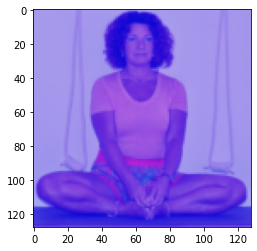

In [32]:
import matplotlib.pyplot as plt

print(f'label: {creator.get_label(int(y[-1]))}')
_ = plt.imshow(X[-1,:,:,:])

## Training

In [0]:
SEED = 42

In [34]:
import tensorflow as tf
tf.__version__

'2.2.0'

### Dataset Partitioning

In [0]:
from sklearn.model_selection import train_test_split

TEST_SET_SIZE = .2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SET_SIZE, random_state=SEED)

In [0]:
VALIDATION_SET_SIZE = 0.2

train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    validation_split=VALIDATION_SET_SIZE
)

train_gen.fit(X_train)

In [0]:
tf.keras.backend.clear_session()

### Dummy classifier

In [0]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="stratified")
dummy_clf.fit(X_train, y_train)
y_pred_dummy = dummy_clf.predict(X_test)

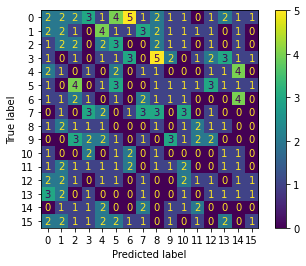

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
listLabel = list(categorical_label_mapping)
le.fit(listLabel)
encodedLabel = le.transform(listLabel)
confusion_matrix(y_test, y_pred_dummy)

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_dummy), np.sort(encodedLabel)).plot()

### Random Search on Convolutional Models

In [0]:
def generate_cnn_model(
    n_conv_layers,
    n_dense_layers,
    n_labels,
    filters=64,
    dense_layer_nodes=64,
    pooling='max',
    dropout_ratio=0.1
):
    
    model = tf.keras.Sequential()
    
    for _ in range(n_conv_layers):
        model.add(tf.keras.layers.Conv2D(64, kernel_size=2))
        if pooling == 'max':
            model.add(tf.keras.layers.MaxPooling2D())
        elif pooling == 'avg':
            model.add(tf.keras.layers.AvgPooling2D())
        else:
            raise Exception("Can only use pooling == max | avg")
        model.add(tf.keras.layers.BatchNormalization())
    
    model.add(tf.keras.layers.Flatten())
    
    for _ in range(n_dense_layers):
        model.add(tf.keras.layers.Dense(dense_layer_nodes, activation='relu'))
        model.add(tf.keras.layers.Dropout(dropout_ratio))
    
    model.add(tf.keras.layers.Dense(n_labels, activation='softmax'))
    return model

In [0]:
def decay_alpha(epoch):
  if epoch < 20:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.1 * (20 - epoch))

In [0]:
BATCH_SIZE = 16
EPOCHS = 100

In [0]:
# HPP's
N_CONV_LAYERS = [ i for i in range(3,6) ]

N_DENSE_LAYERS = [ i for i in range(3,6) ]
DENSE_LAYER_NODES = [2 ** n for n in range(5,9) ]

# try RMSProp & SGD w/ momentum

In [0]:
import random 

N_MODELS = 10
models = []

for _ in range(N_MODELS):
    conv_layers = random.choice(N_CONV_LAYERS)
    
    dense_layers = random.choice(N_DENSE_LAYERS)
    nodes = random.choice(DENSE_LAYER_NODES)
    m = generate_cnn_model(conv_layers, dense_layers, n_labels, dense_layer_nodes=128, dropout_ratio=0.15)
    models.append(m)

In [0]:
results = []
for i, m in enumerate(models):
    m.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    r = m.fit(
        train_gen.flow(X_train, y_train, batch_size=BATCH_SIZE, subset='training'),
        steps_per_epoch = (X_train.shape[0] * (1 - TEST_SET_SIZE - VALIDATION_SET_SIZE)) // BATCH_SIZE,
        epochs=EPOCHS,
        verbose=0,
        # callbacks = [tf.keras.callbacks.LearningRateScheduler(decay_alpha)],
        validation_data=train_gen.flow(X_train, y_train, batch_size=32, subset='validation'),
        validation_steps=(X_train.shape[0] * VALIDATION_SET_SIZE) // BATCH_SIZE
    )
    results.append(r)
    print(f'Finished training model: {i+1}')
    m.evaluate(X_test, y_test, batch_size=16)

Finished training model: 1
17/17 [==============================] - 0s 4ms/step - loss: 2.2825 - accuracy: 0.2308
Finished training model: 2
17/17 [==============================] - 0s 4ms/step - loss: 2.2478 - accuracy: 0.2846
Finished training model: 3
17/17 [==============================] - 0s 4ms/step - loss: 2.2577 - accuracy: 0.2038
Finished training model: 4
17/17 [==============================] - 0s 4ms/step - loss: 2.5146 - accuracy: 0.1385
Finished training model: 5
17/17 [==============================] - 0s 4ms/step - loss: 2.0419 - accuracy: 0.3385
Finished training model: 6
17/17 [==============================] - 0s 4ms/step - loss: 2.7123 - accuracy: 0.1692
Finished training model: 7
17/17 [==============================] - 0s 4ms/step - loss: 2.4773 - accuracy: 0.1846
Finished training model: 8
17/17 [==============================] - 0s 4ms/step - loss: 2.3200 - accuracy: 0.2000
Finished training model: 9
17/17 [==============================] - 0s 4ms/step - loss: 

In [0]:
best_model_idx = 5
models[best_model_idx].summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           multiple                  832       
_________________________________________________________________
max_pooling2d_17 (MaxPooling multiple                  0         
_________________________________________________________________
batch_normalization_17 (Batc multiple                  256       
_________________________________________________________________
conv2d_18 (Conv2D)           multiple                  16448     
_________________________________________________________________
max_pooling2d_18 (MaxPooling multiple                  0         
_________________________________________________________________
batch_normalization_18 (Batc multiple                  256       
_________________________________________________________________
conv2d_19 (Conv2D)           multiple                 

In [0]:
best_model_results = results[best_model_idx] 

#### Evaluation
##### Training Accuracy & Loss

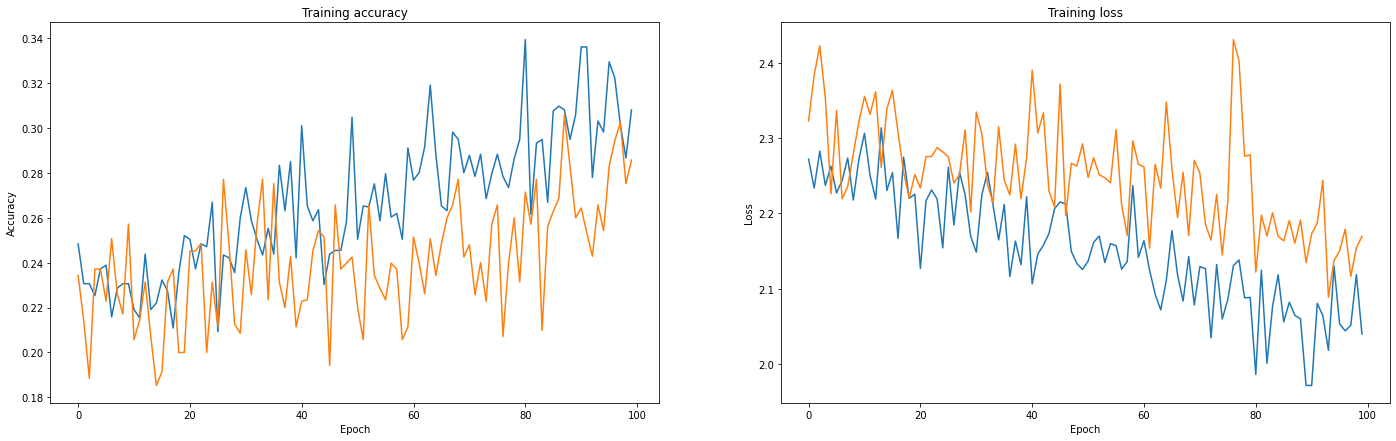

In [0]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24,7))
ax1.plot(best_model_results.history['accuracy'])
ax1.plot(best_model_results.history['val_accuracy'])
ax1.set_title('Training accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax2.plot(best_model_results.history['loss'])
ax2.set_title('Training loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
_ = ax2.plot(best_model_results.history['val_loss'])

##### Confusion Matrix

### Serialize

### Transfer Learning
Follows the discussion [here](https://www.tensorflow.org/tutorials/images/transfer_learning). A list of available models is in the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/applications).

> One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

We want to use the feature representations (which are much richer than what we could generate from our small training set here), but optimize for our specific classification task. So, by setting `include_top` to `False` for the models we can attach a bunch of `tf.keras.layers.Dense` layers to the convolutional layers below. 

The higher (later) convolutional layers in these networks learn more specific feature mappings, whereas the initial ones are more responsible for general image feature mapping. So we can make layers on the backend of these models trainable as well.

**Note:** There are two steps here:
1. One should first train the fully connected top with _all_ the pre-trained model's layers set as non-trainable.
2. Then, we can turn those layers into trainable ones and proceed.

In [0]:
tf.keras.backend.clear_session()

In [0]:
def generate_tl_network(
    n_dense_layers,
    dense_layer_nodes,
    n_labels,
    pretrained_model,
    dropout_ratio=0.1
):  
    model = tf.keras.Sequential()
    model.add(pretrained_model)
    model.add(tf.keras.layers.Flatten())
    
    assert(len(dense_layer_nodes) == n_dense_layers)
    for i in range(n_dense_layers):
        model.add(tf.keras.layers.Dense(dense_layer_nodes[i], activation='relu'))
        model.add(tf.keras.layers.Dropout(dropout_ratio))
    
    model.add(tf.keras.layers.Dense(n_labels, activation='softmax'))
    return model

In [0]:
def decay_alpha_tl(epoch):
  DECAY_EPOCH = 50
  if epoch < DECAY_EPOCH:
    return 0.0001
  else:
    return 0.0001 * tf.math.exp(0.1 * (DECAY_EPOCH - epoch))

In [0]:
N_TL_MODELS = 5
TL_DENSE_LAYERS = [ i for i in range(3,6)]
TL_DENSE_NODES = [ 2 ** i for i in range(5,8)] 
BATCH_SIZE = 16
EPOCHS = 100

#### VGG
##### VGG16

In [0]:
vgg_base_model = tf.keras.applications.VGG16(include_top=False, input_shape=im_shape)
len(vgg_base_model.layers)

19

In [0]:
vgg_base_model.trainable = False

In [0]:
vgg_models, vgg_results = [], []

for i in range(N_TL_MODELS):

    n_fc_layers = random.choice(TL_DENSE_LAYERS)
    n_fc_nodes = [ random.choice(TL_DENSE_NODES) for _ in range(n_fc_layers) ]
    print(f'Setup model with {n_fc_layers} layers: {n_fc_nodes}')
    m = generate_tl_network(n_fc_layers, n_fc_nodes, n_labels, vgg_base_model, 0.2)
    m.compile(tf.keras.optimizers.RMSprop(lr=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    vgg_models.append(m)
    
    r = m.fit(
        train_gen.flow(X_train, y_train, batch_size=BATCH_SIZE, subset='training'),
        steps_per_epoch = (X_train.shape[0] * (1 - TEST_SET_SIZE - VALIDATION_SET_SIZE)) // BATCH_SIZE,
        epochs=EPOCHS,
        verbose=0,
        callbacks = [tf.keras.callbacks.LearningRateScheduler(decay_alpha_tl)],
        validation_data=train_gen.flow(X_train, y_train, batch_size=BATCH_SIZE, subset='validation'),
        validation_steps=(X_train.shape[0] * VALIDATION_SET_SIZE) // BATCH_SIZE
    )
    print(f'Finished training model: {i + 1}')
    m.evaluate(X_test, y_test, batch_size=16)
    vgg_results.append(r)

Setup model with 3 layers: [128, 64, 32]
Finished training model: 1
17/17 [==============================] - 0s 16ms/step - loss: 1.2873 - accuracy: 0.6462
Setup model with 4 layers: [64, 32, 128, 32]
Finished training model: 2
17/17 [==============================] - 0s 15ms/step - loss: 1.6999 - accuracy: 0.4885
Setup model with 5 layers: [128, 64, 32, 32, 128]
Finished training model: 3
17/17 [==============================] - 0s 15ms/step - loss: 1.8750 - accuracy: 0.4385
Setup model with 3 layers: [128, 128, 128]
Finished training model: 4
17/17 [==============================] - 0s 15ms/step - loss: 1.0081 - accuracy: 0.6808
Setup model with 3 layers: [64, 32, 128]
Finished training model: 5
17/17 [==============================] - 0s 16ms/step - loss: 1.4412 - accuracy: 0.5308


In [0]:
best_model_idx = 3
best_model_results = vgg_results[best_model_idx] 

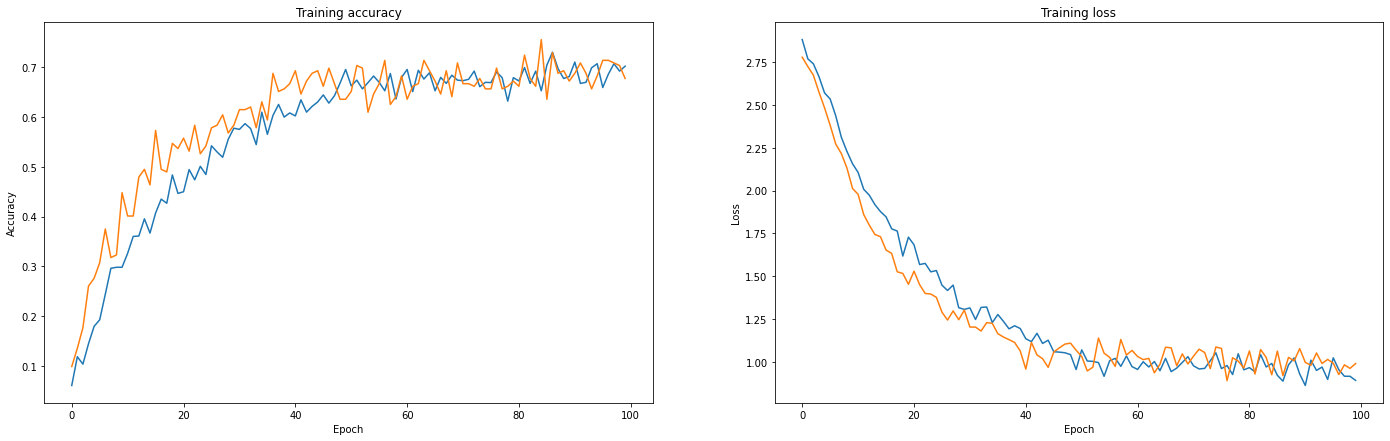

In [0]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24,7))
ax1.plot(best_model_results.history['accuracy'])
ax1.plot(best_model_results.history['val_accuracy'])
ax1.set_title('Training accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax2.plot(best_model_results.history['loss'])
ax2.set_title('Training loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
_ = ax2.plot(best_model_results.history['val_loss'])

In [0]:
vgg_models[best_model_idx].save(f'{GDRIVE_DATA_DIR}/vgg/05-11-20/')

INFO:tensorflow:Assets written to: /content/drive/My Drive/dl-group-spring-20/vgg/05-11-20/assets


##### VGG19

#### DenseNet
##### DenseNet121

In [0]:
densenet_121_base_model = tf.keras.applications.DenseNet121(include_top=False, input_shape=im_shape)
len(densenet_121_base_model.layers)

427

In [0]:
densenet_121_base_model.trainable = False

In [0]:
densenet_models, densenet_results = [], []

for i in range(N_TL_MODELS):

  n_fc_layers = random.choice(TL_DENSE_LAYERS)
  n_fc_nodes = [ random.choice(TL_DENSE_NODES) for _ in range(n_fc_layers) ]
  print(f'Setup model with {n_fc_layers} layers: {n_fc_nodes}')
  m = generate_tl_network(n_fc_layers, n_fc_nodes, n_labels, densenet_121_base_model, 0.2)
  m.compile(tf.keras.optimizers.RMSprop(lr=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  densenet_models.append(m)

  r = m.fit(
      train_gen.flow(X_train, y_train, batch_size=BATCH_SIZE, subset='training'),
      steps_per_epoch = (X_train.shape[0] * (1 - TEST_SET_SIZE - VALIDATION_SET_SIZE)) // BATCH_SIZE,
      epochs=EPOCHS,
      verbose=0,
      callbacks = [tf.keras.callbacks.LearningRateScheduler(decay_alpha_tl)],
      validation_data=train_gen.flow(X_train, y_train, batch_size=BATCH_SIZE, subset='validation'),
      validation_steps=(X_train.shape[0] * VALIDATION_SET_SIZE) // BATCH_SIZE
  )
  print(f'Finished training model: {i + 1}')
  m.evaluate(X_test, y_test, batch_size=16)
  densenet_results.append(r)

Setup model with 3 layers: [128, 32, 32]
Finished training model: 1
17/17 [==============================] - 1s 34ms/step - loss: 1.6309 - accuracy: 0.5769
Setup model with 5 layers: [128, 64, 32, 128, 128]
Finished training model: 2
17/17 [==============================] - 0s 18ms/step - loss: 1.7209 - accuracy: 0.5269
Setup model with 5 layers: [64, 64, 32, 64, 128]
Finished training model: 3
17/17 [==============================] - 0s 19ms/step - loss: 2.3649 - accuracy: 0.2654
Setup model with 5 layers: [128, 32, 128, 32, 32]
Finished training model: 4
17/17 [==============================] - 0s 18ms/step - loss: 2.2601 - accuracy: 0.3154
Setup model with 4 layers: [64, 128, 32, 64]
Finished training model: 5
17/17 [==============================] - 0s 18ms/step - loss: 2.1318 - accuracy: 0.3885


In [0]:
best_model_idx = 0
best_model_results = vgg_results[best_model_idx] 

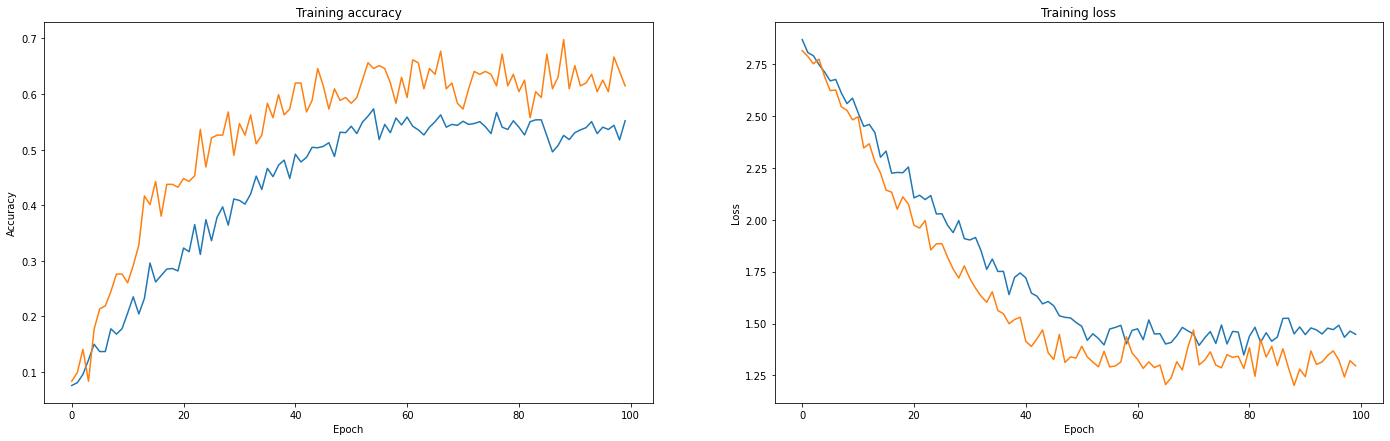

In [0]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(24,7))
ax1.plot(best_model_results.history['accuracy'])
ax1.plot(best_model_results.history['val_accuracy'])
ax1.set_title('Training accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax2.plot(best_model_results.history['loss'])
ax2.set_title('Training loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
_ = ax2.plot(best_model_results.history['val_loss'])

In [0]:
densenet_models[best_model_idx].save(f'{GDRIVE_DATA_DIR}/densenet/05-11-20/')

INFO:tensorflow:Assets written to: /content/drive/My Drive/dl-group-spring-20/densenet/05-11-20/assets


#### Evaluation

##### Confusion Matrix

## Prediction
### VGG

In [0]:
test_idx = 12

label = creator.get_label(int(y_test[test_idx]))
print(y_test[test_idx], label)

plt.imshow(X_test[test_idx])
y_pred = model.predict(np.reshape(X_test[test_idx], tuple([1] + list(X_test[0].shape)))).argmax()
print(y_pred, creator.get_label(int(y_pred)))

### Densenet